# Multi Agent Chat Bot with CoT

I’m ReAct, your intelligent assistant designed to Reason and Take Actions effectively. 

To support you better, I work alongside three specialized subagents:

Docu-Talk: Your go-to expert for document-related queries.

Ask-Finance: Here to assist with all your finance-related questions.

General bot - Your friendly co-pilot


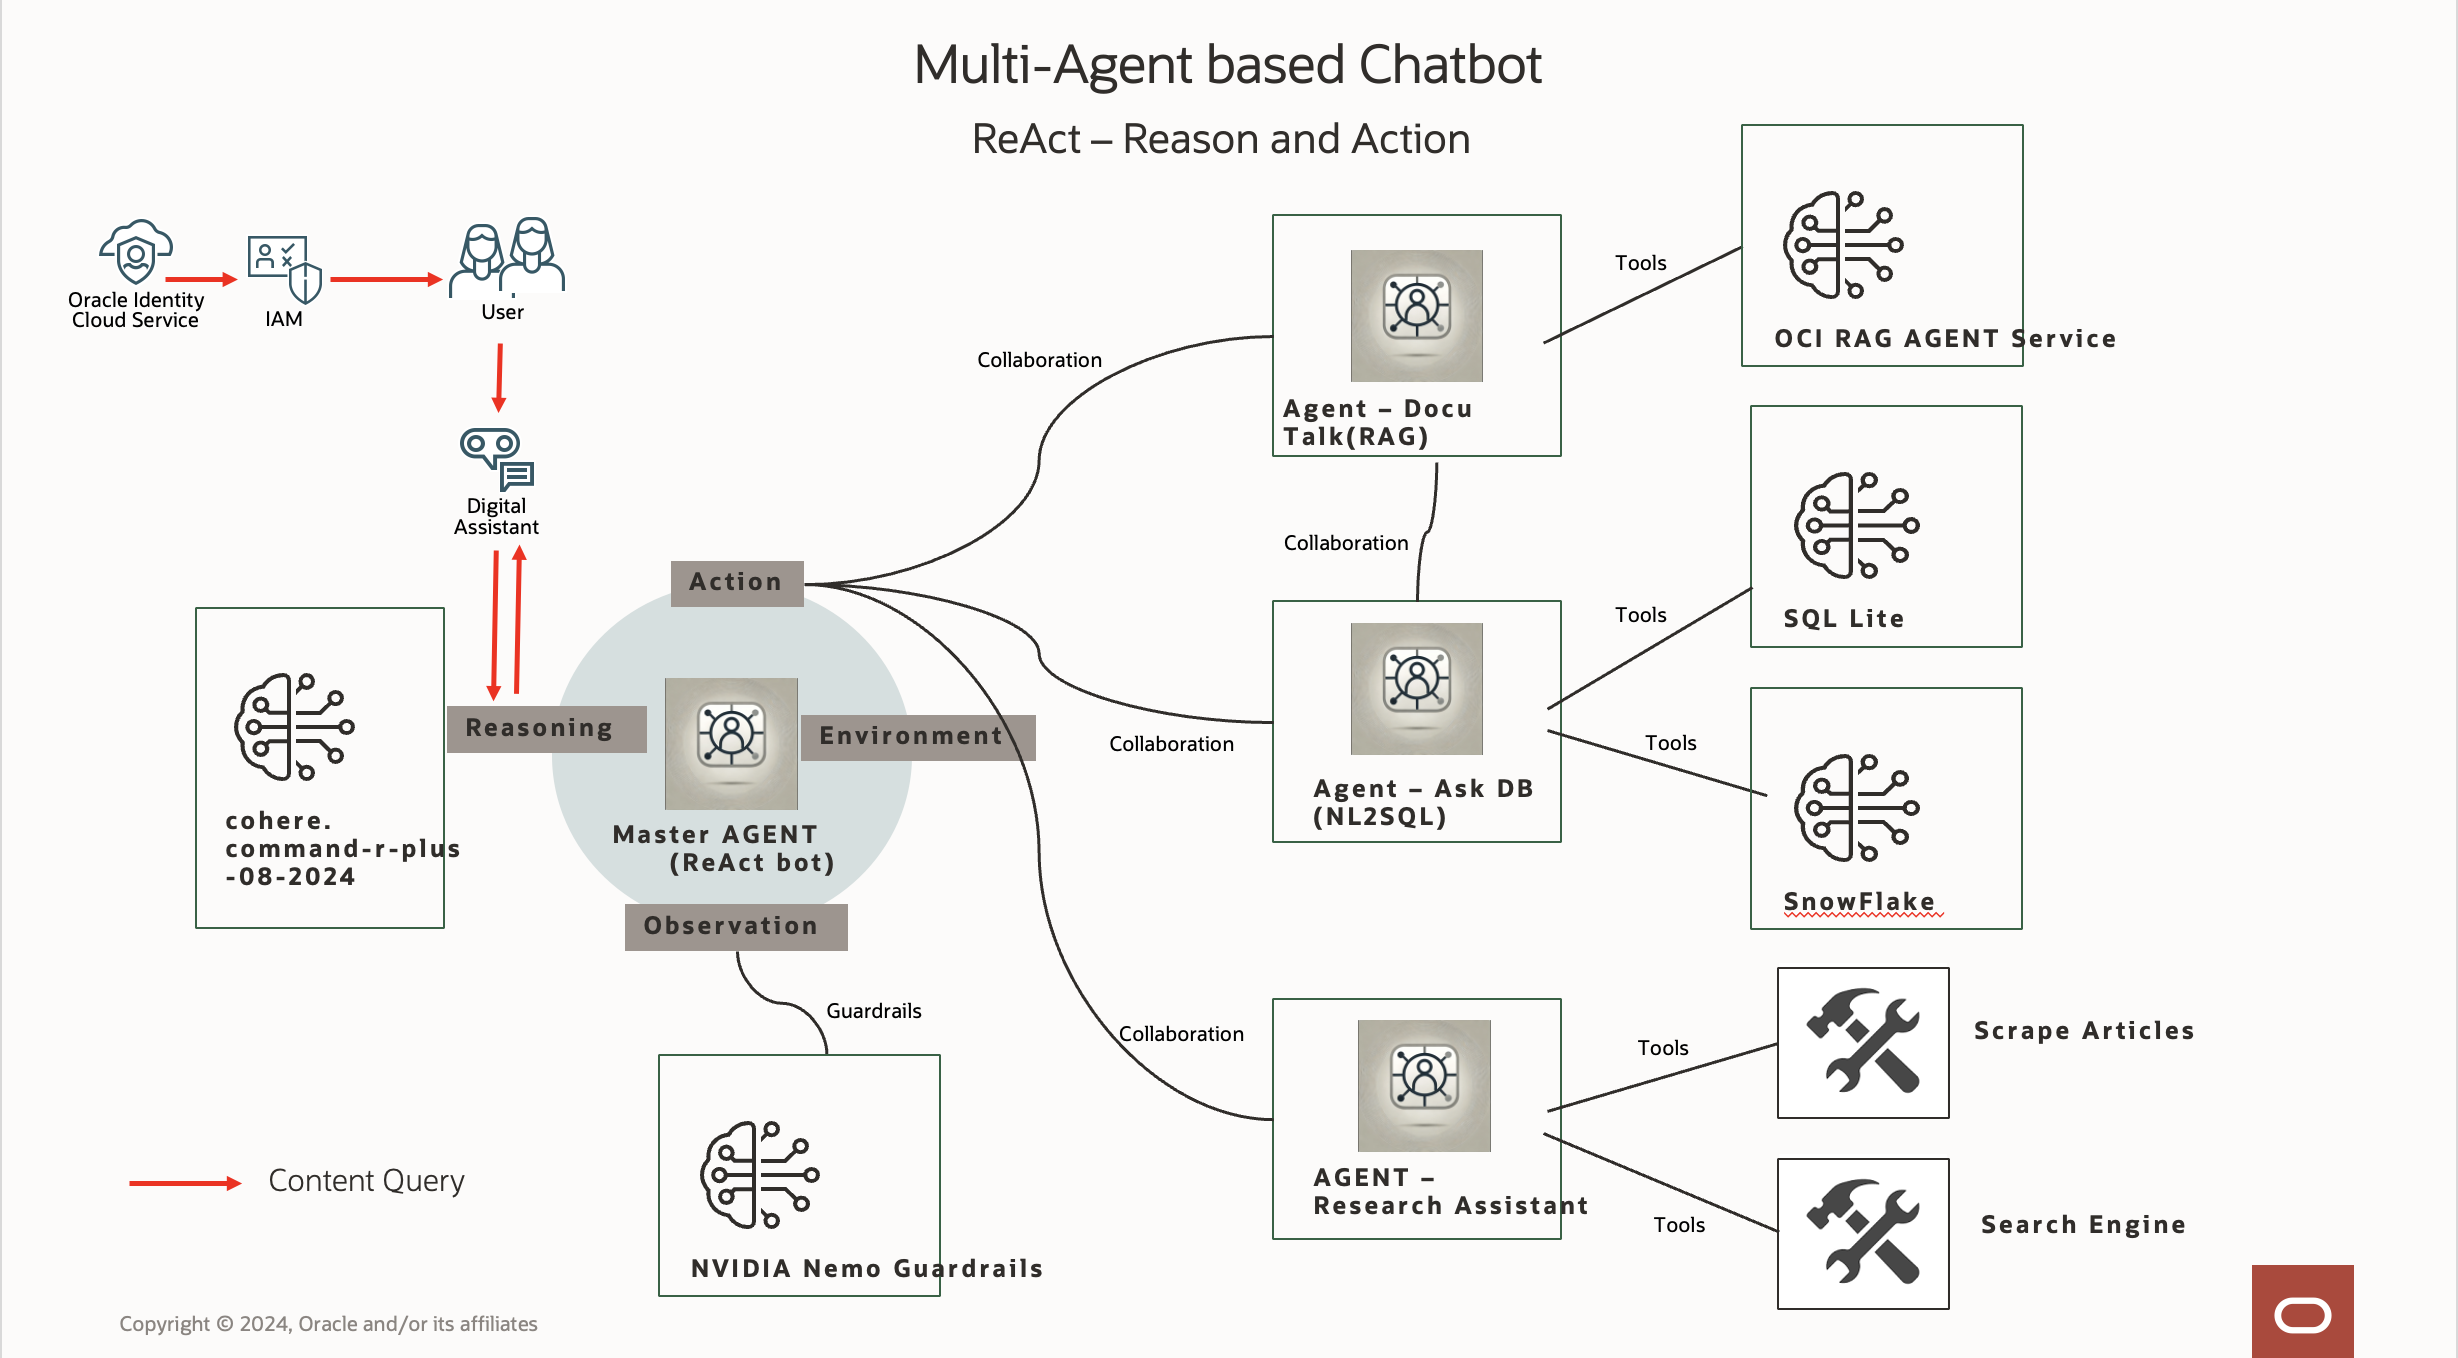

In [126]:
from IPython.display import Image

Image("images/multi-agent-react-1.png", width=1000, height=600)

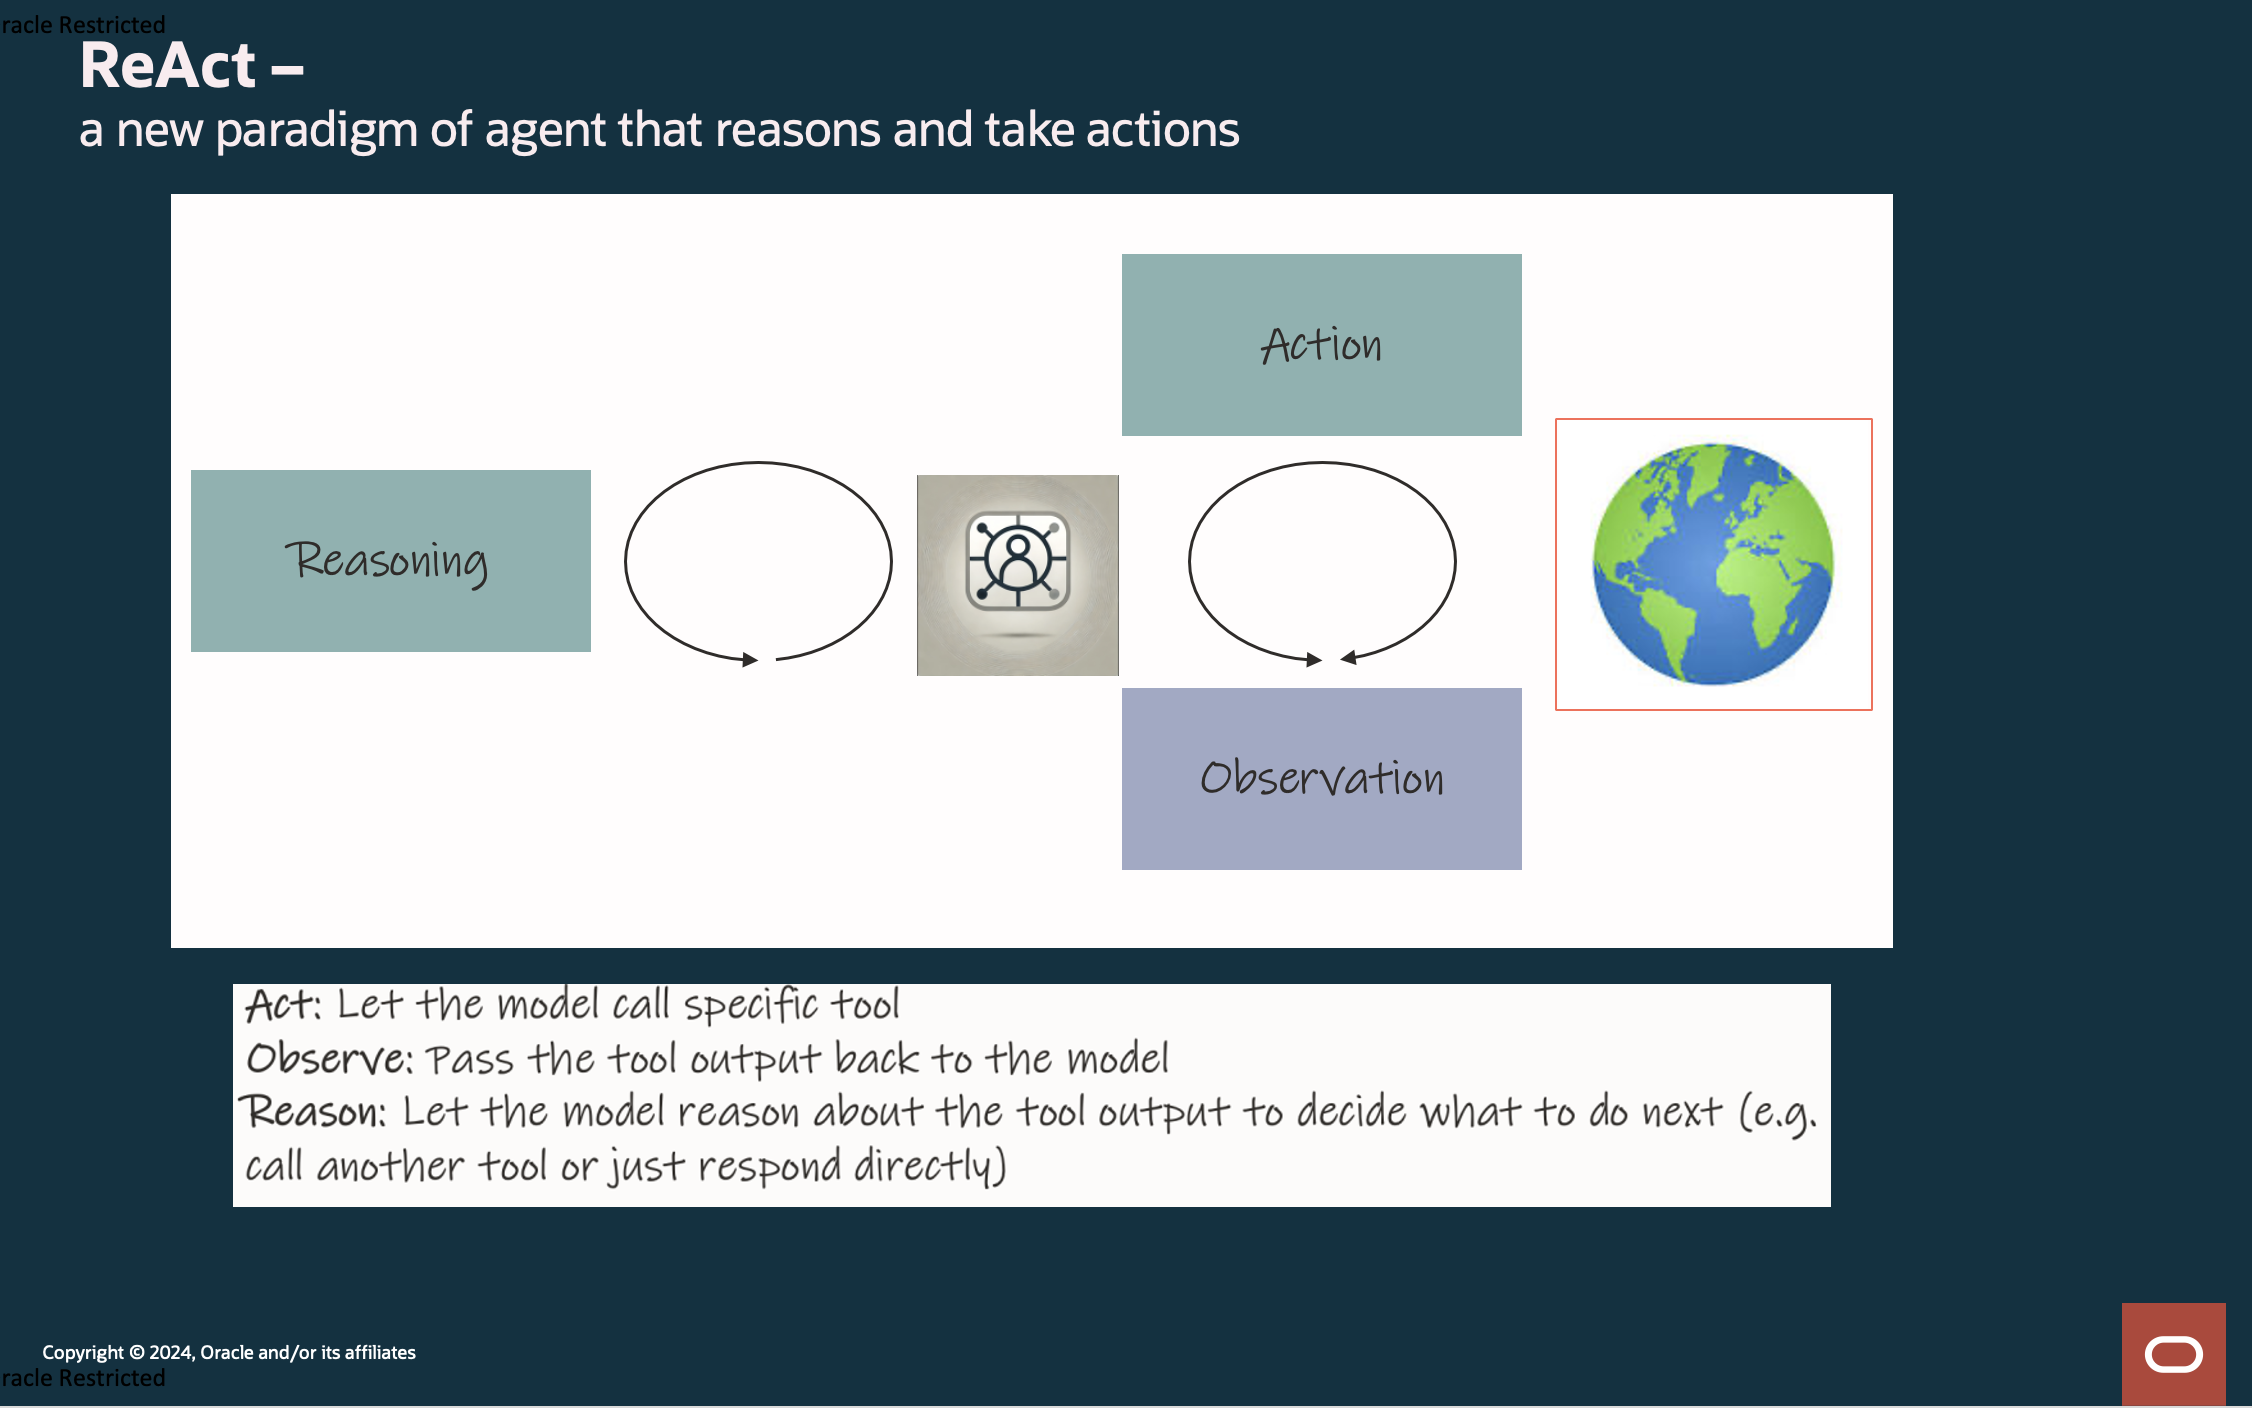

In [127]:
from IPython.display import Image
Image("images/react.png", width=1000, height=600)

# An Orchestration Pattern

An Orchestration Pattern in an Agentic Framework refers to the structured coordination of agents and processes to execute a task or workflow effectively. Here an LLM with Reasoning capabilities can be used as the Orchestrator, often called a Master agent. The Master agent dynamically assigns (unlike Routing pattern, the subtasks aren't pre-defined) task to worker agents, responsible for coordinating and overseeing the collaborative tasks of worker agents, and later reduces the final output.
This pattern is well suited for building complex Multi-Agent System. For Example:
A user uploads a pdf that has both text and images embedded to a chatbot and ask to summarize. The Master agent decides to orchestrate multiple worker agents – one for analyzing text to text, and another one to analyze image to text. The final output is later synthesized (post-process) and presented to the user.



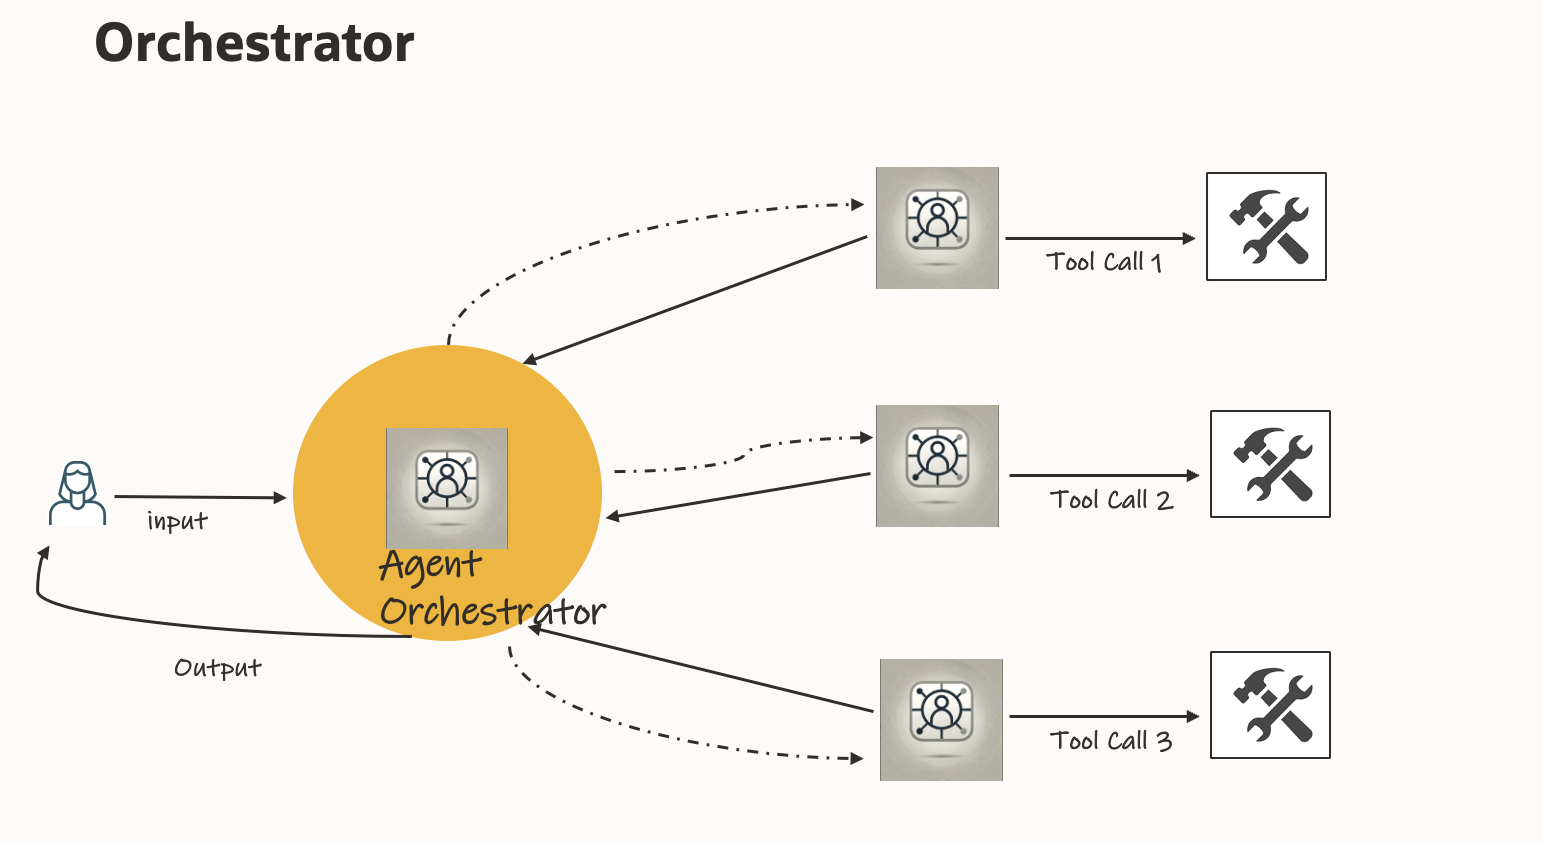

In [129]:
from IPython.display import Image
Image("images/multi-agent.png", width=1000, height=600)


## Setup

First, let's install our required packages and set our API keys

In [130]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_experimental
%pip install -U snowflake-connector-python snowflake-sqlalchemy sqlalchemy
# !wget https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite

### LLM from OCI GenAI Servvices - Config

In [131]:
from langchain_community.chat_models.oci_generative_ai import ChatOCIGenAI
from langchain.prompts import PromptTemplate  # For creating prompts 


# Set your OCI credentials 
compartment_id = "ocid1.compartment.oc1..aaaaaaaau6esoygdsqxfz6iv3u7ghvosfskyvd6kroucemvyr5wzzjcw6aaa" 
service_endpoint = "https://inference.generativeai.us-chicago-1.oci.oraclecloud.com" 
#model_id = "meta.llama-3.3-70b-instruct"
model_id = "cohere.command-r-plus-08-2024"
# Create an OCI Cohere LLM instance 
llm_oci = ChatOCIGenAI(
    model_id= model_id,  # Specify the model you want to use 
    service_endpoint=service_endpoint,
    compartment_id=compartment_id,
    model_kwargs={"temperature": 0.7, "top_p": 0.75, "max_tokens": 1000}
) 


### OCI GenAI RAG Agent Service - Config

In [202]:
import oci
from langchain_core.tools import tool

from oci.generative_ai_agent_runtime import GenerativeAiAgentRuntimeClient
from oci.generative_ai_agent_runtime.models import CreateSessionDetails

# Set up the OCI GenAI Agents endpoint configuration
agent_ep_id = "ocid1.genaiagentendpoint.oc1.us-chicago-1.amaaaaaawe6j4fqaye4c3tcmg6rehfougltaikbo763b3v4tcyraac6snvfa"
config = oci.config.from_file(profile_name="DEFAULT") # Update this with your own profile name
service_ep = "https://agent-runtime.generativeai.us-chicago-1.oci.oraclecloud.com" # Update this with the appropriate endpoint for your region, a list of valid endpoints can be found here - https://docs.oracle.com/en-us/iaas/api/#/en/generative-ai-agents-client/20240531/
sess_id = ""
def initialize_oci_genai_agent_service():
    """Initialize OCI GenAI Agent Service and create a session"""
       
    # Initialize service client with default config file
    generative_ai_agent_runtime_client = oci.generative_ai_agent_runtime.GenerativeAiAgentRuntimeClient(config,service_endpoint=service_ep)

    # Create Session
    create_session_response = generative_ai_agent_runtime_client.create_session(
        create_session_details=oci.generative_ai_agent_runtime.models.CreateSessionDetails(
            display_name="USER_Session",
            description="User Session"),
        agent_endpoint_id=agent_ep_id)

    sess_id = create_session_response.data.id
    
    #print("generative_ai_agent_runtime_client :" + str(generative_ai_agent_runtime_client))
    #print(sess_id)
    
    
    return generative_ai_agent_runtime_client, sess_id  # Return both client and session ID

In [203]:
initialize_oci_genai_agent_service()

(<oci.generative_ai_agent_runtime.generative_ai_agent_runtime_client.GenerativeAiAgentRuntimeClient at 0x7fa64bd54d10>,
 'ocid1.genaiagentsession.oc1.us-chicago-1.amaaaaaa7mjirbaampcap7lzmipjrbzliym743i67gyiasp7niqjfdrvmwlq')

### Setup all required keys

In [180]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("SNOWFLAKE_USER")
_set_if_undefined("SNOWFLAKE_PASSWORD")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Create Tools

Each team will be composed of one or more agents each with one or more tools. Below, define all the tools to be used by your different teams.

We'll start with the Search team.



# Setup Agent - Ask DB

In [205]:
# sql lite install
# !wget https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite

## Sql Lite Connector

Connect to the SQLite database using the LangChain SQLDatabase utility:

In [206]:
from langchain_community.utilities import SQLDatabase
db_path = "cookbook.db"
#db_path = "/kaggle/input/chinook-sample-database/chinook.db"
uri = f"sqlite:///{db_path}"
db = SQLDatabase.from_uri(uri)


## Clean SQL Queries
This function is very important. We often see this problem in many of our client’s projects that the SQL query generated from the LLM consists of some unnecessary symbols, texts, backticks, etc. As a result, you will get an error while executing this query. Thus, we require a function to clean up these additional texts.

In [207]:
import re

def clean_sql_query(text: str) -> str:
    """
    Clean SQL query by removing code block syntax, various SQL tags, backticks,
    prefixes, and unnecessary whitespace while preserving the core SQL query.

    Args:
        text (str): Raw SQL query text that may contain code blocks, tags, and backticks

    Returns:
        str: Cleaned SQL query
    """
    # Step 1: Remove code block syntax and any SQL-related tags
    # This handles variations like ```sql, ```SQL, ```SQLQuery, etc.
    block_pattern = r"```(?:sql|SQL|SQLQuery|mysql|postgresql)?\s*(.*?)\s*```"
    text = re.sub(block_pattern, r"\1", text, flags=re.DOTALL)

    # Step 2: Handle "SQLQuery:" prefix and similar variations
    # This will match patterns like "SQLQuery:", "SQL Query:", "MySQL:", etc.
    prefix_pattern = r"^(?:SQL\s*Query|SQLQuery|MySQL|PostgreSQL|SQL)\s*:\s*"
    text = re.sub(prefix_pattern, "", text, flags=re.IGNORECASE)

    # Step 3: Extract the first SQL statement if there's random text after it
    # Look for a complete SQL statement ending with semicolon
    sql_statement_pattern = r"(SELECT.*?;)"
    sql_match = re.search(sql_statement_pattern, text, flags=re.IGNORECASE | re.DOTALL)
    if sql_match:
        text = sql_match.group(1)

    # Step 4: Remove backticks around identifiers
    text = re.sub(r'`([^`]*)`', r'\1', text)

    # Step 5: Normalize whitespace
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # Step 6: Preserve newlines for main SQL keywords to maintain readability
    keywords = ['SELECT', 'FROM', 'WHERE', 'GROUP BY', 'HAVING', 'ORDER BY',
               'LIMIT', 'JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN',
               'OUTER JOIN', 'UNION', 'VALUES', 'INSERT', 'UPDATE', 'DELETE']

    # Case-insensitive replacement for keywords
    pattern = '|'.join(r'\b{}\b'.format(k) for k in keywords)
    text = re.sub(f'({pattern})', r'\n\1', text, flags=re.IGNORECASE)

    # Step 7: Final cleanup
    # Remove leading/trailing whitespace and extra newlines
    text = text.strip()
    text = re.sub(r'\n\s*\n', '\n', text)

    return text


### Snowflake DB Connector

In [208]:
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
from sqlalchemy import create_engine, text

engine_snowflake = create_engine(URL(
    account = "RZPKOZP-HOB20238",
    user = os.getenv("SNOWFLAKE_USER"),
    password = os.getenv("SNOWFLAKE_PASSWORD"),
    role = "ACCOUNTADMIN",
    warehouse = "COMPUTE_WH",
    database = "SNOWFLAKE_SAMPLE_DATA",
    schema = "TPCH_SF100"
))

from langchain_community.utilities import SQLDatabase
from langchain.agents import create_sql_agent


## Initialize LangChain SQLDatabase
db_snowflake = SQLDatabase(engine_snowflake)

# Test connection
# Create an SQLAlchemy connection
with engine_snowflake.connect() as connection:
    result = connection.execute(text("SELECT CURRENT_VERSION();"))
    print(f"Connected! Snowflake Version: {result.fetchone()[0]}")


Connected! Snowflake Version: 9.5.2


## Create the Ask DB (NL2SQL) Tool
Define a tool that generates and executes SQL queries:

### 1. Tool using SnowFlake

In [209]:
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
#from langchain_community.tools import QuerySQLDatabaseTool
from operator import itemgetter
from pydantic import BaseModel, Field
from langchain_core.tools import tool
import re
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate

class SQLToolSchema(BaseModel):
    question: str

@tool(args_schema=SQLToolSchema)
def nl2sql_agent_service_sf(question):
    """Tool to Generate and Execute SQL Query to answer User Questions related to Customer Order"""
    print(" >> INSIDE SNOWFLAKE NL2SQL TOOL ")
    execute_query = QuerySQLDataBaseTool(db=db_snowflake)
    write_query = create_sql_query_chain(llm_oci, db_snowflake)

    chain = (
       RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
           result=itemgetter("query") | execute_query
       )
    )
    
    preamble = "Tool to Generate and Execute SQL Query to answer User Questions related to cookbook DB"
    prompt = ChatPromptTemplate.from_messages([
    SystemMessage(content=preamble),  # System message
    ("human", "{question}")])

    
    # Extracting the content
    response = chain.invoke({"question": question})
   
    return response


In [210]:
# Unit Test Cases - 
question = "what are all the top 5 customer ?"
result = nl2sql_agent_service_sf.invoke({"question": question})
print(f"Answer: {result}")

 >> INSIDE SNOWFLAKE NL2SQL TOOL 
Answer: {'question': 'what are all the top 5 customer ?', 'query': 'SELECT c_name \nFROM customer \nORDER BY c_custkey DESC \nLIMIT 5;', 'result': "[('Customer#015000000',), ('Customer#014999999',), ('Customer#014999998',), ('Customer#014999997',), ('Customer#014999996',)]"}


In [139]:
#from langchain_community.utilities import SQLDatabase
#from langchain.agents import AgentType


## Initialize LangChain SQLDatabase
#db_snowflake = SQLDatabase(engine_snowflake)

## Create an agent that can query Snowflake

#agent_executor = create_sql_agent(llm=llm_oci, db=db_snowflake, agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION, handle_parsing_errors=True, verbose=True)

## Ask the agent to run a SQL query
#query_result = agent_executor.run("What are the top 5 customers?")
#print(query_result)


### 2. Tool using SQL Lite

In [211]:
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from operator import itemgetter
from pydantic import BaseModel, Field
from langchain_core.tools import tool
import re
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate

class SQLToolSchema(BaseModel):
    question: str

@tool(args_schema=SQLToolSchema)
def nl2sql_agent_service(question):
    """Tool to Generate and Execute SQL Query to answer User Questions related to cookbook DB"""
    print("INSIDE NL2SQL TOOL")
    execute_query = QuerySQLDataBaseTool(db=db)
    write_query = create_sql_query_chain(llm_oci, db)

    chain = (
       RunnablePassthrough.assign(query=write_query | RunnableLambda(clean_sql_query)).assign(
           result=itemgetter("query") | execute_query
       )
    )
    
    preamble = "Tool to Generate and Execute SQL Query to answer User Questions related to cookbook DB"
    prompt = ChatPromptTemplate.from_messages([
    SystemMessage(content=preamble),  # System message
    ("human", "{question}")])

    
    # Extracting the content
    response = chain.invoke({"question": question})
    
    # Store the response in memory
    #key = str(uuid.uuid4())  # Unique key for each entry
    #memory_store.put(memory_namespace, key, {"question": question, "response": response})

    
    return response


In [212]:
# Unit Test Cases
question = "what is the recipe for Jewell Ball'S Chicken ?"
result = nl2sql_agent_service.invoke({"question": question})
print(f"Answer: {result}")

INSIDE NL2SQL TOOL
Answer: {'question': "what is the recipe for Jewell Ball'S Chicken ?", 'query': "SELECT ingredients, directions \nFROM recipes \nWHERE title = 'Jewell Ball''S Chicken' \nLIMIT 1;", 'result': '[(\'["1 small jar chipped beef, cut up", "4 boned chicken breasts", "1 can cream of mushroom soup", "1 carton sour cream"]\', \'["Place chipped beef on bottom of baking dish.", "Place chicken on top of beef.", "Mix soup and cream together; pour over chicken. Bake, uncovered, at 275\\\\u00b0 for 3 hours."]\')]'}


## Setup Agent - Research Assistant

### 1. Tools for Realtime Intternet based Search Engine

In [188]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=3)

### 2. Tools for Web Scrapping

In [217]:
from langchain_core.tools import tool
from typing import Annotated, List
from langchain_community.document_loaders import WebBaseLoader


from langchain_community.document_loaders import WebBaseLoader
from bs4 import BeautifulSoup
import requests
import re
from typing import List

@tool
def scrape_webpages(query: str, urls: List[str]) -> str:
    """
    **Improved Web Scraper Tool**
    
    This tool scrapes ONLY the provided URLs for relevant information related to the query.

    **Enhancements:**
    - ✅ **Ensures URLs are provided & valid**
    - ✅ **Uses BeautifulSoup for better content extraction**
    - ✅ **Filters & ranks content based on semantic relevance**
    - ✅ **Summarizes results to improve readability**

    **Example Usage:**
    ```python
    scrape_webpages("Latest AI advancements", ["https://ai-news.com/latest"])
    ```
    """

    if not urls:
        return "Error: No URLs provided for scraping."

    extracted_content = []

    for url in urls:
        try:
            # Load webpage content
            response = requests.get(url, timeout=10)
            response.raise_for_status()  # Ensure the request was successful
            soup = BeautifulSoup(response.text, "html.parser")

            # Extract relevant text from paragraphs
            paragraphs = [p.get_text().strip() for p in soup.find_all("p")]
            full_text = "\n".join(paragraphs)

            # Improve text cleaning (remove excessive whitespace, JavaScript remnants, etc.)
            cleaned_text = re.sub(r"\s+", " ", full_text)

            # Extract only relevant sentences
            relevant_sentences = [
                sentence for sentence in cleaned_text.split(". ")
                if any(word.lower() in sentence.lower() for word in query.split())
            ]

            if relevant_sentences:
                extracted_content.append(f"📄 **[{url}]**\n" + ". ".join(relevant_sentences))

        except requests.exceptions.RequestException as e:
            extracted_content.append(f"❌ Error fetching {url}: {str(e)}")

    # Return formatted content or an error message
    if extracted_content:
        return "\n\n".join(extracted_content)
    else:
        return f"⚠️ No relevant content found for query: {query}"



In [144]:
# Unit Test cases - 

scrape_webpages.invoke({"query": "Latest AI advancements in 2024", "urls": ["https://www.bbc.com/news/articles/clyz6e9edy3o"]})



'📄 **[https://www.bbc.com/news/articles/clyz6e9edy3o]**\nA complex problem that took microbiologists a decade to get to the bottom of has been solved in just two days by a new artificial intelligence (AI) tool. Professor José R Penadés and his team at Imperial College London had spent years working out and proving why some superbugs are immune to antibiotics. He gave "co-scientist" - a tool made by Google - a short prompt asking it about the core problem he had been investigating and it reached the same conclusion in 48 hours. He told the BBC of his shock when he found what it had done, given his research was not published so could not have been found by the AI system in the public domain. "I was shopping with somebody, I said, \'please leave me alone for an hour, I need to digest this thing,\'" he told the Today programme, on BBC Radio Four. "I wrote an email to Google to say, \'you have access to my computer, is that right?\'", he added. The full decade spent by the scientists also i

## Setup Agent - OCI RAG AGENT SERVICE

The OCI RAG Agent Service is a pre-built service from Oracle cloud, that is designed to perform multi-modal augmented search against any pdf (with embedded tables and charts) or txt files.


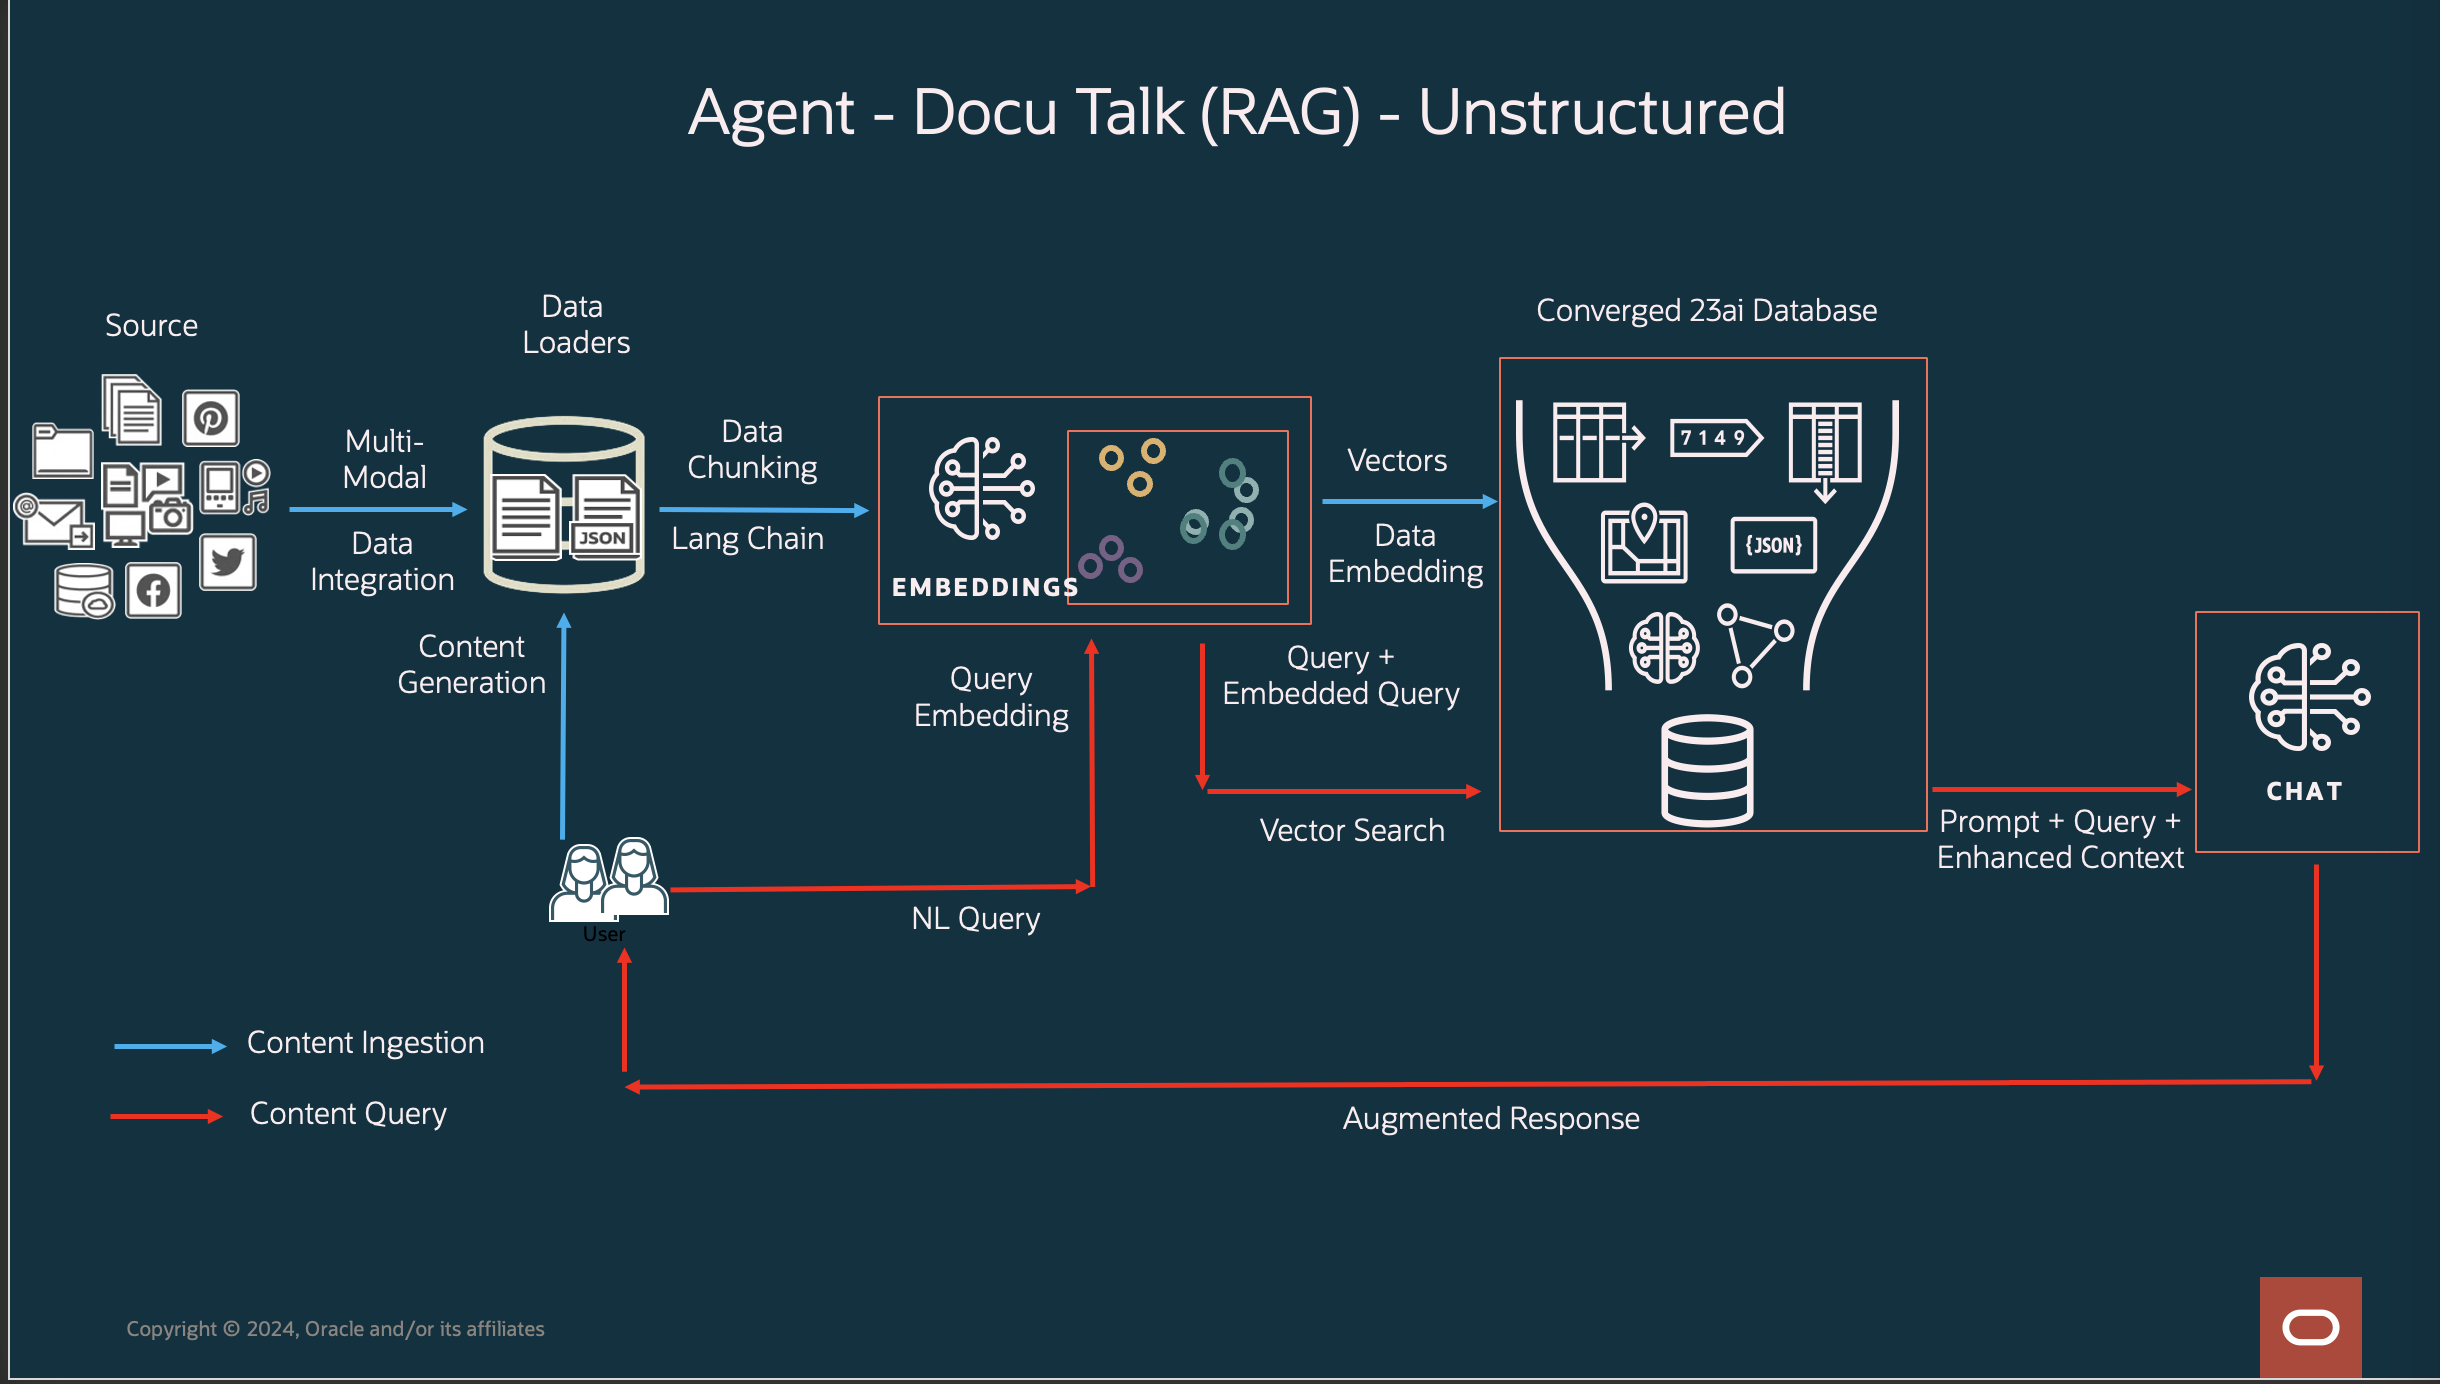

In [218]:
from IPython.display import Image
Image("images/rag.png", width=1000, height=800)

### 1. Tools for RAG Search against unstructured data

In [191]:
import oci
from langchain_core.tools import tool

    
# Response Generator
@tool
def rag_agent_service(input) -> str:
    """Any questions about how to create a good recipe, use the rag_agent tool. Don't use search or Web_Scrapper for questions related to Tax"""
    
    generative_ai_agent_runtime_client, sess_id = initialize_oci_genai_agent_service()
    response = generative_ai_agent_runtime_client.chat(
        agent_endpoint_id=agent_ep_id,
        chat_details=oci.generative_ai_agent_runtime.models.ChatDetails(
            user_message=input,
            session_id=sess_id))
 
    
    
    #print(str(response.data))
    response = response.data.message.content.text
    return response
 

In [192]:
# Test Cases - 

answer = rag_agent_service.invoke("how to create a good recipe")

print(answer)

Creating a good recipe involves a combination of following established procedures, incorporating your creative flair, and understanding how to balance flavors. Here are some key steps to help you develop delicious recipes:

1. Read the recipe thoroughly from beginning to end before starting any preparation. This habit gives you a comprehensive understanding of the procedures, techniques, and ingredients required. It also helps you visualize the cooking process and identify any potential challenges or areas that need clarification.

2. Gather all the necessary equipment, including cutting boards, knives, mixing bowls, measuring utensils, pots, and any specialized tools mentioned in the recipe. Having everything within reach ensures a smoother and more efficient cooking process.

3. Understand the concept of "mis en place," which means having everything in its place. Prepare and measure all your ingredients in advance, just like professional chefs do to maximize efficiency during service

## Setup Master Agent

We are going to create a few utility functions to make it more concise when we want to:

1. Create a worker agent.
2. Create a supervisor for the sub-graph.

These will simplify the graph compositional code at the end for us so it's easier to see what's going on.

### 1. Ceate A Supervisor

In [219]:
import json
import re
from typing import List, Optional, Literal, TypedDict
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage


class State(MessagesState):
    next: str


def extract_json(text: str) -> dict:
    """
    Extracts a valid JSON object from the text using regex.
    If multiple JSON objects exist, it picks the first one.
    """
    json_pattern = re.findall(r'\{.*?\}', text, re.DOTALL)
    
    for json_str in json_pattern:
        try:
            parsed_json = json.loads(json_str)

            # Handle nested JSON cases
            if isinstance(parsed_json, dict):
                if "supervisor" in parsed_json and "next" in parsed_json["supervisor"]:
                    return {"next": parsed_json["supervisor"]["next"]}
                if "next" in parsed_json:
                    return parsed_json
        except json.JSONDecodeError:
            continue  # Try the next match if this one fails
    
    return {"next": "FINISH"}  # Default if no valid JSON is found


def make_supervisor_node(llm: BaseChatModel, members: list[str]):
    """
    Supervisor function responsible for routing user queries to the appropriate LangGraph sub-agent.
    It ensures that:
      - How to create a good recipe are handled by **RAG**
      - General knowledge-based queries are handled by **Web_Scrapper**
      - Internet-specific queries are handled by **search**
      - Natural language to SQL queries about recipe are handled by **nl2sql**
      - Natural language to SQL queries about customers are handled by **nl2sql_sf**
    """

    options = ["FINISH"] + members
    system_prompt = """
    Supervisor function responsible for routing user queries to the appropriate LangGraph sub-agent.
    It ensures that:
      - how to create a good recipe are handled by **RAG**
      - Ability to scrape a webpage when an URL is provided and extract information **Web_Scrapper**
      - Internet-specific queries are handled by **search**
      - Natural language to SQL queries about recipe are handled by **nl2sql**
      - Natural language to SQL queries about customers are handled by **nl2sql_sf**

    Your role is to intelligently route queries to the correct sub-agent while ensuring efficiency. 
    Avoid redundant tool calls, and if a tool fails, escalate to the next available option.
    If no relevant tool is found or the conversation is complete, return: {"next": "FINISH"}.

    ### **Available Agents & Responsibilities**
    - **RAG** → Handles **how to create a good recipe questions** 
    - **Web_Scrapper** → Handles **general knowledge questions** that require web scraping.
    - **search** → Handles **real-time internet-based queries** (news, weather, current events).
    - **nl2sql** → Handles **natural language to SQL translation queries about recipe ** for database access.
    - **nl2sql_sf** → Handles **natural language to SQL translation queries about customers ** for database access.

    ### **Routing Rules**
    1. **how to create a good recipe** → Route to **RAG**.  
    2. **Scrape a webpage when an URL is provided and extract information → Route to **Web_Scrapper**.  
    3. **Real-time, internet-based questions** (live data like weather, news) → Route to **search**.  
    4. **Database queries in natural language about recipes** → Route to **nl2sql**.  
    5. **Database queries in natural language about customers** → Route to **nl2sql_sf**.  
    5️⃣ **Do not call the same tool twice in succession** unless needed. If a tool fails, escalate to another tool if applicable.  
    6️⃣ **If no relevant tool is found, or conversation is complete, return:** {"next": "FINISH"}.

    ### **Examples for Better Routing**
    ❌ **Avoid vague or incorrect routing decisions. Follow these examples:**  

    **Example 1: good recipe**  
    **User:** how to create a good recipe?  
    **Response:** {"next": "RAG"}  

    **Example 2: Scrape a webpage*  
    **User:** Find recent research papers on quantum computing. , [https://arxiv.org/list/quant-ph/recent].  
    **Response:** {"next": "Web_Scrapper"}  

    **Example 3: Real-Time Query (Internet-based)**  
    **User:** What is the temperature of Louisville KY today?  
    **Response:** {"next": "search"}  

    **Example 4: NL to SQL Conversion Query about recipes**  
    **User:** what is the recipe for Jewell Ball'S Chicken ?.  
    **Response:** {"next": "nl2sql"}  
    
    **Example 5: NL to SQL Conversion Query about customers**  
    **User:** what are the top 5 customers ?.  
    **Response:** {"next": "nl2sql_sf"}  

    **Example 5: Conversation is Complete**  
    **User:** Thanks, that’s all I needed.  
    **Response:** {"next": "FINISH"}  
    """


    class Router(TypedDict):
        """Worker to route to next. If no workers are needed, route to FINISH."""
        next: Literal[tuple(options)]  # Corrected Literal usage

    def supervisor_node(state: State) -> Command[Literal[tuple(members) + ("__end__",)]]:
        """An LLM-based router for LangGraph-based sub-agents."""
        
        messages = [HumanMessage(content=system_prompt)] + state["messages"]
        
        # Get LLM response
        response_text = llm.invoke(messages).content  # Ensure we extract .content
        #print(response_text)
        response = extract_json(response_text)  # Use robust JSON extraction
        goto = response.get("next", "FINISH")  # Default to FINISH if missing
        
        # Ensure valid routing
        if goto not in members:
            print(f"⚠️ route received: {goto}, defaulting to FINISH")
            goto = "FINISH"

        if goto == "FINISH":
            goto = END

        print(f"📌 Routing user to: {goto}")  # Debugging log
        return Command(goto=goto, update={"next": goto})

    return supervisor_node


## 2. Define your Agent Teams

Now we can get to define our hierarchical teams. "Choose your player!"

### The team will have ReAct capabilities

The ReAct team will have a RAG agent and a NL2SQL "react_agent" as the two worker nodes. Let's create those, as well as the team supervisor.

In [225]:
# TEST CASES FOR ENABLING REACT CAPABILITY
from langchain.agents import AgentType, initialize_agent
from langchain.tools import Tool



# Define tools (example tool)
def dummy_tool(input_text):
    return f"Processed: {input_text}"

tools = [Tool(name="DummyTool", func=dummy_tool, description="A test tool")]

# Initialize the ReAct agent manually
react_agent = initialize_agent(
    tools=tools,
    llm=llm_oci,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)

# Test the agent
print(react_agent.run("I have 2 pen. One is red in color and another one is black. I gave the black pen to my son. How many pen do I have? And what is the color?"))




> Entering new AgentExecutor chain...
Thought: To answer this question, I need to determine how many pens are left with the person after giving one to their son.
Action: DummyTool
Action Input: I have 2 pen. One is red in color and another one is black. I gave the black pen to my son. How many pen do I have? And what is the color?
Observation: Processed: I have 2 pen. One is red in color and another one is black. I gave the black pen to my son. How many pen do I have? And what is the color?
Thought:Thought: The question is asking about the remaining pens after giving one to the son. I need to clarify that the person has one pen left, and it is red.
Final Answer: You have one pen left, and it is red.

> Finished chain.
You have one pen left, and it is red.


### Define ReAct Nodes for all the agents and Tools built so far

In [236]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
#from langgraph.prebuilt import create_react_agent
import re
#from langgraph.prebuilt import ToolNode
#from langgraph.prebuilt import tools_condition
from langchain.agents import AgentType, initialize_agent

# Initialize the ReAct agent manually

######### RAG Agent ########### 
rag_agent = initialize_agent(
    tools=[rag_agent_service],
    llm=llm_oci,
    #agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, ### OCI RAG Doesn't support this feature
    verbose=True
)


def rag_node(state: State) -> Command[Literal["supervisor"]]:
    # Ensure state is a dictionary
    if isinstance(state, dict):
        messages = state.get("messages", [])
    else:
        messages = state.messages  # If it's an object, use its attribute

    # Extract last user message
    if messages:
        user_input = messages[-1].content
    else:
        raise ValueError("No messages found in state")

    # 🚀 Debugging: Print the extracted message
    print("User Input Received:", user_input)

    # Invoke the agent service
    result = rag_agent_service.invoke({"input": user_input})

    # 🚀 Debugging: Print the raw agent response
    print("Agent Response:", result)

    # Handle case where result is a string instead of a dictionary
    if isinstance(result, str):
        result = {"output": result}  # Convert to dictionary format

    # Ensure result contains expected keys
    if not isinstance(result, dict):
        raise TypeError(f"Expected a dictionary but got {type(result)} instead.")

    if "output" not in result:
        raise KeyError(f"Expected key 'output' missing. Available keys: {list(result.keys())}")

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["output"], name="RAG")
            ]
        },
        goto="supervisor",
    )


######### Research Assistant Agent ########### 

#search_agent = create_react_agent(llm_oci, tools=[tavily_tool])
search_agent = initialize_agent(
    tools=[tavily_tool],
    llm=llm_oci,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
)


def search_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    # Ensure state is treated as a dictionary
    if isinstance(state, dict):
        messages = state.get("messages", [])
    else:
        messages = state.messages  # If it's an object, use its attribute

    # Extract last user message
    if messages:
        user_input = messages[-1].content
    else:
        raise ValueError("No messages found in state")

    # Invoke the nl2sql agent
    result = search_agent.invoke({"input": user_input})

    # 🚀 Debugging: Print the response structure
    #print("Agent Output Type:", type(result))
    #print("Agent Output Content:", result)

    # Ensure result contains expected keys
    if not isinstance(result, dict):
        raise TypeError(f"Expected a dictionary but got {type(result)} instead.")

    if "output" not in result:
        raise KeyError(f"Expected key 'output' missing. Available keys: {list(result.keys())}")

    # Use 'output' instead of 'messages'
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["output"], name="search")
            ]
        },
        goto="supervisor",
    )

#web_scraper_agent = create_react_agent(llm_oci, tools=[scrape_webpages])


import json

def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    # Ensure state is a dictionary
    if isinstance(state, dict):
        messages = state.get("messages", [])
    else:
        messages = state.messages  # If it's an object, use its attribute

    # Extract last user message
    if messages:
        user_message = messages[-1].content
    else:
        raise ValueError("No messages found in state")

    # 🚀 Debugging: Print the raw user message
    print("User Message Received:", user_message)

    # Ensure user_message is not empty
    if not user_message.strip():
        raise ValueError("Received an empty user message.")

    # Attempt to parse JSON properly
    try:
        # If user_message is already a dictionary (not a string), use it directly
        if isinstance(user_message, dict):
            parsed_input = user_message
        else:
            # Replace single quotes with double quotes for valid JSON format
            parsed_input = json.loads(user_message.replace("'", '"'))

        query = parsed_input.get("query")
        urls = parsed_input.get("urls")

        # Ensure both query and urls exist
        if not query or not isinstance(urls, list):
            raise ValueError("Parsed input does not contain both 'query' and a list of 'urls'.")

    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid input format. Expected JSON-like structure. Error: {str(e)}")

    # Invoke the web scraping tool with structured input
    result = scrape_webpages.invoke({"query": query, "urls": urls})

    # 🚀 Debugging: Print the scraped content
    print("Scraped Content:", result)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result, name="Web_Scrapper")
            ]
        },
        goto="supervisor",
    )



######### Ask DB Agent ########### 

nl2sql_agent = initialize_agent(
    tools=[nl2sql_agent_service],
    llm=llm_oci,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True
)


def nl2sql_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    # Ensure state is treated as a dictionary
    if isinstance(state, dict):
        messages = state.get("messages", [])
    else:
        messages = state.messages  # If it's an object, use its attribute

    # Extract last user message
    if messages:
        user_input = messages[-1].content
    else:
        raise ValueError("No messages found in state")

    
    # Invoke the nl2sql agent
    result = nl2sql_agent.invoke({"input": user_input})

    # 🚀 Debugging: Print the response structure
    #print("Agent Output Type:", type(result))
    #print("Agent Output Content:", result)

    # Ensure result contains expected keys
    if not isinstance(result, dict):
        raise TypeError(f"Expected a dictionary but got {type(result)} instead.")

    if "output" not in result:
        raise KeyError(f"Expected key 'output' missing. Available keys: {list(result.keys())}")

    # Use 'output' instead of 'messages'
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["output"], name="nl2sql")
            ]
        },
        goto="supervisor",
    )


nl2sql_sf_agent = initialize_agent(
    tools=[nl2sql_agent_service_sf],
    llm=llm_oci,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True
)

def nl2sql_sf_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    # Ensure state is treated as a dictionary
    if isinstance(state, dict):
        messages = state.get("messages", [])
    else:
        messages = state.messages  # If it's an object, use its attribute

    # Extract last user message
    if messages:
        user_input = messages[-1].content
    else:
        raise ValueError("No messages found in state")

    # Invoke the nl2sql agent
    result = nl2sql_sf_agent.invoke({"input": user_input})

    # 🚀 Debugging: Print the response structure
    #print("Agent Output Type:", type(result))
    #print("Agent Input Content:", result["input"])
    #print("Agent Output Content:", result["output"])

    # Ensure result contains expected keys
    if not isinstance(result, dict):
        raise TypeError(f"Expected a dictionary but got {type(result)} instead.")

    if "output" not in result:
        raise KeyError(f"Expected key 'output' missing. Available keys: {list(result.keys())}")

    # Use 'output' instead of 'messages'
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["output"], name="nl2sql_sf")
            ]
        },
        goto="supervisor",
    )


# Bring all the agents togather - Supervisro Agent
research_supervisor_node = make_supervisor_node(llm_oci, ["RAG", "Web_Scrapper", "search", "nl2sql", "nl2sql_sf"])

### Now Build the Graph for execution

Now that we've created the necessary components, defining their interactions is easy. Add the nodes to the team graph, and define the edges, which determine the transition criteria.

In [237]:
from langgraph.checkpoint.memory import MemorySaver

research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("RAG", rag_node)
research_builder.add_node("search", search_node)
research_builder.add_node("Web_Scrapper", web_scraper_node)
research_builder.add_node("nl2sql", nl2sql_node)
research_builder.add_node("nl2sql_sf", nl2sql_sf_node)

research_builder.add_edge(START, "supervisor")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer and store
research_graph_memory = research_builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)
research_graph = research_builder.compile()

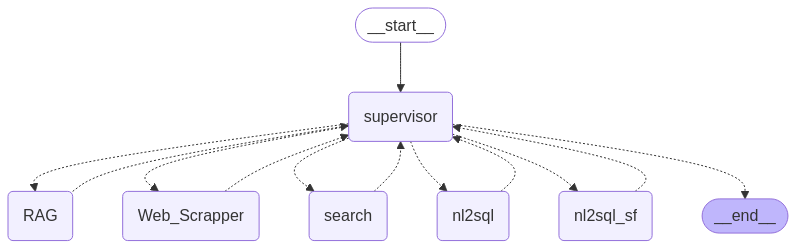

In [238]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

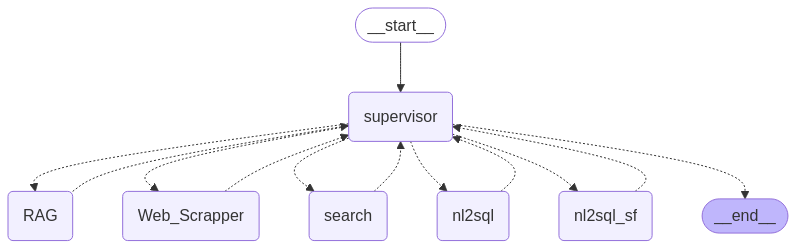

In [239]:
from IPython.display import Image, display

display(Image(research_graph_memory.get_graph().draw_mermaid_png()))

#### Memory Management across the multi-agent system

In [240]:
from langgraph.store.memory import InMemoryStore
import uuid

# Initialize in-memory store
memory_store = InMemoryStore()

# Define a namespace for memory (can be per user or per conversation)
user_id = "aojah1"
memory_namespace = (user_id, "multi_agent_memory")


We can give this team work directly. Try it out below.

In [241]:
# Extract content from response dictionary
def print_message(response):
    memory = ""
    if isinstance(response, dict):
        for agent, data in response.items():
            if "messages" in data and data["messages"]:
                #print("Store this in memory::")
                memory = data["messages"][-1].content
    else:
        print("Store this in memory: ")
        
    return memory

In [242]:
# Test without memory - RAG Use Case
# User input 

initialize_oci_genai_agent_service()
question = [HumanMessage(content="how to create a good vegetarian recipe ?")]

for s in research_graph.stream(
    {"messages": question},
    {"recursion_limit": 100}
):
    print_message(s)
    print("---")

📌 Routing user to: RAG
---
User Input Received: how to create a good vegeterian recipe ?
Agent Response: Creating delicious and nutritious vegetarian recipes is an art, and the book *Cooking Vegetarian* offers a wealth of insights and recipes in this regard. The book emphasizes healthful, delicious, and easy-to-prepare dishes, taking readers on a culinary journey from breakfast to desserts. 

One key aspect of creating flavorful vegetarian recipes is understanding the importance of ingredients and their combinations. The book mentions the scrumptious aroma of baked potatoes, the hearty warmth of rice pudding, and the explosion of flavors in a toasted sandwich with fresh tomatoes and avocado. These sensory experiences are central to the appeal of vegetarian cuisine. 

Additionally, the book offers practical tips, such as recommending a visit to a specialty kitchen knife store to gain knowledge about purchasing, utilizing, and maintaining knives, which is essential for any cook. 

While 

In [243]:
# Test without memory - NL2SQL - SQLLITE
# User input 
question = [HumanMessage(content="what is the recipe for Jewell Ball'S Chicken ?")]

for s in research_graph.stream(
    {"messages": question},
    {"recursion_limit": 100}
):
    print_message(s)
    print("---")

📌 Routing user to: nl2sql
---


> Entering new AgentExecutor chain...
Thought: I need to find the recipe for 'Jewell Ball's Chicken'. I can use the database to find this information.
Action: nl2sql_agent_service
Action Input: recipe for Jewell Ball'S ChickenINSIDE NL2SQL TOOL

Observation: {'question': "recipe for Jewell Ball'S Chicken", 'query': "SELECT ingredients \nFROM recipes \nWHERE title = 'Jewell Ball''S Chicken' \nLIMIT 1;", 'result': '[(\'["1 small jar chipped beef, cut up", "4 boned chicken breasts", "1 can cream of mushroom soup", "1 carton sour cream"]\',)]'}
Thought:Thought: The query returned the ingredients for the recipe 'Jewell Ball's Chicken'.
Final Answer: The recipe for Jewell Ball's Chicken includes the following ingredients:
- 1 small jar chipped beef, cut up
- 4 boned chicken breasts
- 1 can cream of mushroom soup
- 1 carton sour cream

> Finished chain.
---
⚠️ route received: FINISH, defaulting to FINISH
📌 Routing user to: __end__
---


In [245]:
# Test WITH in-memory - NL2SQL - SQLLITE
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
# Enable Chat Capability of the Agent to execute this prompt

config = {"configurable": {"thread_id": "3", "user_id": "aojah1"}}

# what is the recipe for Jewell Ball'S Chicken ?
# What is the most important ingredients?
# User input 
question = [HumanMessage(content="what is the recipe for Jewell Ball'S Chicken ?")]


# Run the graph
for chunk in research_graph_memory.stream({"messages": question}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what is the recipe for Jewell Ball'S Chicken ?
📌 Routing user to: nl2sql
================================ Human Message =================================

what is the recipe for Jewell Ball'S Chicken ?


> Entering new AgentExecutor chain...
Thought: I need to find the recipe for Jewell Ball's Chicken.
Action: nl2sql_agent_service
Action Input: "what is the recipe for Jewell Ball'S Chicken ?"INSIDE NL2SQL TOOL

Observation: {'question': "what is the recipe for Jewell Ball'S Chicken ?", 'query': "SELECT ingredients, directions \nFROM recipes \nWHERE title = 'Jewell Ball''S Chicken' \nLIMIT 1;", 'result': '[(\'["1 small jar chipped beef, cut up", "4 boned chicken breasts", "1 can cream of mushroom soup", "1 carton sour cream"]\', \'["Place chipped beef on bottom of baking dish.", "Place chicken on top of beef.", "Mix soup and cream together; pour over chicken. Bake, uncovered, at 275\\\\u00b0 for 3 hours."]

In [246]:
# Test WITHOUT in-memory - NL2SQL - SnowFlake
try:
    # what are the top 5 customers based on orders placed
    # which nation has the highest order placed?
    # Customer from which nation has the highest order placed?
    # What was that total amount of business done ?
    # What was that total amount of business done for customers from Iraq?
    for s in research_graph.stream(
        {"messages": [("user", "what are the top 5 customers based on orders placed?")]},
        {"recursion_limit": 100}
    ):
        print_message(s) 
        print("---")
except Exception as e:
    print("")  # Logs the error

📌 Routing user to: nl2sql_sf
---


> Entering new AgentExecutor chain...
Thought: To answer this question, I need to identify the top 5 customers who have placed the most orders. I will use the 'nl2sql_agent_service_sf' tool to generate and execute an SQL query.
Action: nl2sql_agent_service_sf
Action Input: Query: top 5 customers based on orders placed >> INSIDE SNOWFLAKE NL2SQL TOOL 

Observation: {'question': 'Query: top 5 customers based on orders placed', 'query': 'SELECT T1.c_name, COUNT(T2.o_orderkey) AS num_orders \nFROM customer AS T1 \nINNER JOIN orders AS T2 ON T1.c_custkey = T2.o_custkey \nGROUP BY T1.c_name \nORDER BY num_orders DESC \nLIMIT 5', 'result': "[('Customer#008205778', 44), ('Customer#013234366', 44), ('Customer#007396357', 44), ('Customer#011791942', 43), ('Customer#011159161', 43)]"}
Thought:Thought: The SQL query has successfully retrieved the top 5 customers based on the number of orders placed. I will now present the results in a clear and concise manner.
Fi

In [247]:

import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())

# The value needs to be a dictionary  
value = {"food_preference" : "I like pizza"}

# Save the memory
in_memory_store.put(namespace_for_memory, key, value)
memories = in_memory_store.search(namespace_for_memory)
memories[0].dict()


{'namespace': ['1', 'memories'],
 'key': '30aec27a-4cb9-4944-8787-bedc1f7777dc',
 'value': {'food_preference': 'I like pizza'},
 'created_at': '2025-03-11T13:57:41.580984+00:00',
 'updated_at': '2025-03-11T13:57:41.580986+00:00',
 'score': None}

In [248]:
# Test WITH in-memory - NL2SQL - SnowFlake
# Enable Structured output behaviour of the Agent to execute this use case

import uuid
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import HumanMessage

# Initialize in-memory store
in_memory_store = InMemoryStore()

# Define a namespace for storage
user_id = "aojah1"
namespace_for_memory = (user_id, "nl2sql_sf")  # Tuple format

# Generate a unique key for storing memory
key = str(uuid.uuid4())

# The value needs to be a dictionary  
question = "what are the top 5 customers based on orders placed?"
value = {}  # Initialize as a dictionary

# Define config for memory storage
config = {
    "configurable": {"thread_id": "1", "user_id": user_id},
    "recursion_limit": 100
}

try:
    # Run the research graph
    for s in research_graph.stream(
        {"messages": [HumanMessage(content=question)]},  # Fix input format
        config
    ):
        memory_value = print_message(s)  # Capture the returned value
        #print("Captured Memory Value:", memory_value)

        # Ensure valid memory before storing
        if memory_value:
            value[question] = str(memory_value)  # Store as dictionary
            #print("Value to Store:", value)

        # Save memory in InMemoryStore
        if value:  
            in_memory_store.put(namespace_for_memory, key, value)
            print("Memory successfully stored!")

        # **Debug: Check stored memory using search()**
        memories = in_memory_store.search(namespace_for_memory)

        if memories:
            print("Stored Memory Key:", memories[0].key)
            print("Stored Memory Value:", memories[0].value)
        else:
            print("No memories found in the store.")

except Exception as e:
    print("Error:", e)


📌 Routing user to: nl2sql_sf
No memories found in the store.


> Entering new AgentExecutor chain...
Thought: To answer this question, I need to find the top 5 customers who have placed the most orders. I will use the 'nl2sql_agent_service_sf' tool to generate and execute a SQL query.
Action: nl2sql_agent_service_sf
Action Input: Find the top 5 customers with the most orders placed. >> INSIDE SNOWFLAKE NL2SQL TOOL 

Observation: {'question': 'Find the top 5 customers with the most orders placed.', 'query': 'SELECT T1.c_name, COUNT(T2.o_orderkey) AS num_orders \nFROM customer AS T1 \nINNER JOIN orders AS T2 ON T1.c_custkey = T2.o_custkey \nGROUP BY T1.c_name \nORDER BY num_orders DESC \nLIMIT 5', 'result': "[('Customer#008205778', 44), ('Customer#013234366', 44), ('Customer#007396357', 44), ('Customer#011791942', 43), ('Customer#011159161', 43)]"}
Thought:Thought: The query returned the top 5 customers based on the number of orders placed. The customers are 'Customer#008205778', 'Custom

In [166]:
# Test - Search Criteria

try:
    for s in research_graph.stream(
        {"messages": [("user", "What is the temperature of Louisville KY today the March/11/2025?")]},
        {"recursion_limit": 100},
        #subgraphs=True
    ):
        print_message(s)
        print("---")
except Exception as e:
    print("")  # Logs the error

📌 Routing user to: search
---


> Entering new AgentExecutor chain...
Thought: I need to find out the temperature in Louisville, KY, on March 12, 2025. I can use the search tool to find this information.
Action: tavily_search_results_json
Action Input: Louisville KY temperature March 12 2025
Observation: [{'title': 'Parameter: Date_Time | Short-term heat stress assay - BCO-DMO', 'url': 'https://www.bco-dmo.org/dataset-parameter/914799', 'content': "Parameter: Date_Time | Short-term heat stress assay: Temperature data | BCO-DMO Skip to main content Submit Data Access Data Resources Database 53 Programs 1,697 Projects 3,501 Deployments 7,034 Datasets 1,619 Parameters 115 Funding Contribute Data » submit.bco-dmo.org » How-to Guide » FAQs BCO-DMO Blog Find out what's happening at BCO-DMO. Parameter: Date_Time Dataset:\xa0 Short-term heat stress assay: Temperature data Parameter:\xa0 Date and time Master parameters information Short Name: Short Description: Date and time No Data Value: Desc

In [125]:
# Test - Web Search Criteria
import json

try:
    for s in research_graph.stream(
        {
            "messages": [
                {
                    "role": "user",
                    "content": json.dumps({
                        "query": "Latest AI advancements in 2024",
                        "urls": ["https://www.bbc.com/news/articles/clyz6e9edy3o"]
                    })
                }
            ]
        },
        {"recursion_limit": 100},
    ):
        print_message(s)
        print("---")

except Exception as e:
    print("")  # Logs the error


📌 Routing user to: search
---


> Entering new AgentExecutor chain...
To answer the question about the latest AI advancements in 2024, I should first consider what information is currently available on this topic. Given the provided URLs, it seems there might be some relevant information, but to get a comprehensive overview, I should also look into more recent and broad sources.

Action: tavily_search_results_json
Action Input: "AI advancements 2024"
Observation: [{'title': '2024: A year of extraordinary progress and advancement in AI', 'url': 'https://blog.google/technology/ai/2024-ai-extraordinary-progress-advancement/', 'content': 'Google released Gemini 2.0, a powerful AI model designed for the "agentic era," and integrated it into various products. We furthered our industry-leading research in AI safety, developing new tools and techniques and integrating these advances into our latest models. We expanded SynthID’s capabilities to watermarking AI-generated text in the Gemini app a